In [7]:
# conda install -c conda-forge tabulate
# pip install shutils
#pip install zipfile38


SyntaxError: invalid syntax (1716058883.py, line 5)

In [1]:
#@markdown #1. Install the dependencies 
#dependency conflict 
#DEFINING THE FUNCTIONS

from tabulate import tabulate
from astropy.visualization import simple_norm

from ipywidgets import interact

import numpy as np
import skimage.io
import skimage.filters
import matplotlib.pyplot as plt
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave


#Structural similarity (SSIM) index for measuring image quality #can probably change the sigma
def ssim(img1, img2):
  return structural_similarity(img1,img2,data_range=1.,full=True, gaussian_weights=True, use_sample_covariance=False, sigma=1.5)


def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):#dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x

def norm_minmse(gt, x, normalize_gt=True):
    """This function is adapted from Martin Weigert"""

    """
    normalizes and affinely scales an image pair such that the MSE is minimized  
     
    Parameters
    ----------
    gt: ndarray
        the ground truth image      
    x: ndarray
        the image that will be affinely scaled 
    normalize_gt: bool
        set to True of gt image should be normalized (default)
    Returns
    -------
    gt_scaled, x_scaled 
    """
    if normalize_gt:
        gt = normalize(gt, 0.1, 99.9, clip=False).astype(np.float32, copy = False)
    x = x.astype(np.float32, copy=False) - np.mean(x)    
    gt = gt.astype(np.float32, copy=False) - np.mean(gt)    
    scale = np.cov(x.flatten(), gt.flatten())[0, 1] / np.var(x.flatten())
    return gt, scale * x

In [ ]:
# #@markdown #2. Run this cell to connect your Google Drive to Colab

# #@markdown * Click on the URL. 

# #@markdown * Sign in your Google Account. 

# #@markdown * Copy the authorization code. 

# #@markdown * Enter the authorization code. 

# #@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# #mounts user's Google Drive to Google Colab.

# from google.colab import drive
# drive.mount('/content/gdrive')

(11, 10, 512, 512)
The Previous frame will be used as a reference
---------------------------
Stack shape: (11, 512, 512)


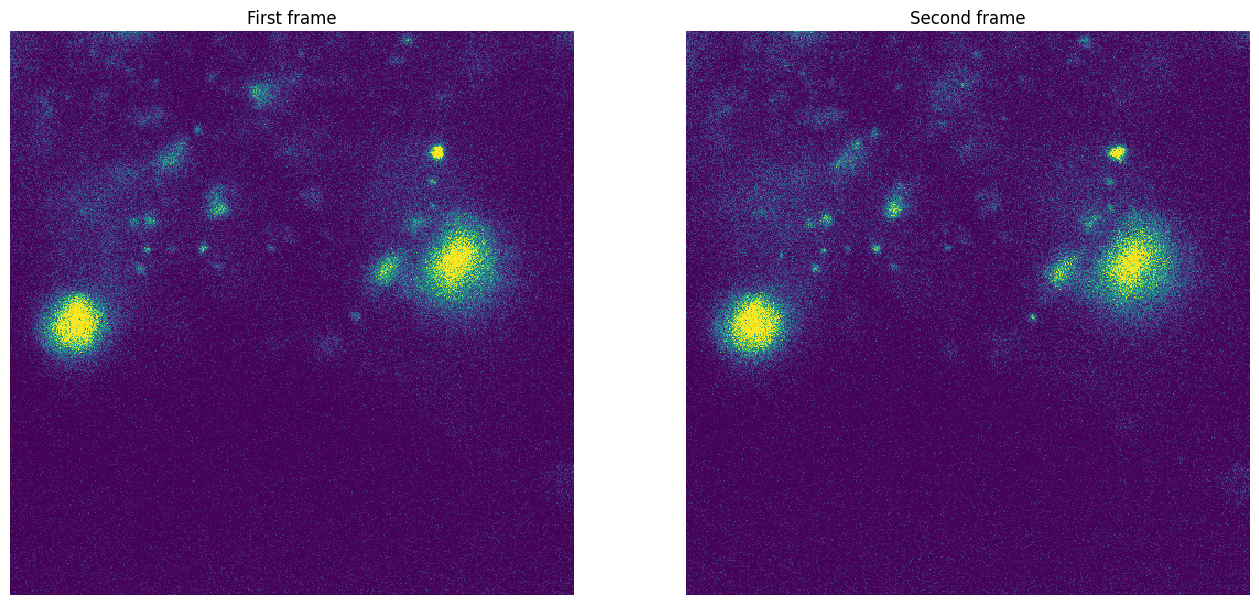

In [38]:
#@markdown #3. Choose the folders that contain the data to analyse and run to load the data. One example will be displayed

Source_folder = "//Users/secchim/Downloads/CellProfiler/movies_split_channels" #@param{type:"string"}
Result_folder = "/Users/secchim/Downloads/CellProfiler/movies_split_channels_extra" #@param{type:"string"}

Analysis_type = "Z-slice" #@param ["Max_projection", "Z-slice"]

Reference_Frame = "Previous" #@param ["First", "Previous"]


#@markdown ##If not Max_projection, choose the Z plane to analyse
Z_plane =  5#@param {type:"number"}

# -------------------------------- Load the stack --------------------------------

random_choice=random.choice(os.listdir(Source_folder))

stack = imread(Source_folder+"/"+random_choice)

print(stack.shape)

if Reference_Frame == "Previous":           
  print('The Previous frame will be used as a reference')

if Reference_Frame == "First": 
  print('The First frame will be used as a reference')


# perform the max projection

if Analysis_type == "Max_projection":
  #make max projection
  maxproj = np.max(stack[:,:,:,:],axis = 1)
  print('---------------------------')
  print('max projection shape', maxproj.shape)


if Analysis_type == "Z-slice":
  maxproj = stack[:,Z_plane,:,:]

  print('---------------------------')
  print('Stack shape:', maxproj.shape)



#Display one image

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(maxproj[0], norm=simple_norm(maxproj[0], percent = 99), interpolation='nearest')

plt.axis('off')
plt.title('First frame');
plt.subplot(1,2,2)
plt.imshow(maxproj[1], norm=simple_norm(maxproj[1], percent = 99), interpolation='nearest')
plt.axis('off')
plt.title('Second frame');






In [ ]:
# image_test = imread(Source_folder+"/"+random_choice)
# image_test.shape
# #image_test[:,Z_plane,:,:].shape

In [39]:
#@markdown #4. Process the data

#The source folder must contain both the unprocessed and processed file, or run it twice on both folders
#separate output folder

import csv
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr

if Analysis_type == "Max_projection":
  Z_plane = ""


for i in os.listdir(Source_folder):
  if not os.path.isdir(os.path.join(Source_folder,i)):
    print('Running QC on: '+i)
    if i.startswith('VWF') and i.endswith('.tif'): #added that line because one hidden file was not tif in the folder
      stack = imread(Source_folder+"/"+i)

      if Analysis_type == "Max_projection":
    
        maxproj = np.max(stack[:,:,:,:],axis = 1)

      if Analysis_type == "Z-slice":
        maxproj = stack[:,Z_plane,:,:]

  # Open and create the csv file that will contain all the QC metrics
      with open(Result_folder+"/"+"QC_metrics_"+i+"_"+Analysis_type+str(Z_plane)+"_"+Reference_Frame+".csv", "w", newline='') as file:
          writer = csv.writer(file)

      # Write the header in the csv file
          writer.writerow(["image #","Z plane","Z plane + 1", "mSSIM", "NRMSE", "PSNR", "Pearson coefficient"])  

          # Initialize the lists
          Z_plane_list = []
          ssim_score_list = []
          Pearson_correlation_coefficient_list = []
            
      # Let's loop through the provided dataset in the QC folders

          for z in range(maxproj.shape[0]-1):

            Z_plane_list.append(z)            
        # -------------------------------- Load the data --------------------------------
            if Reference_Frame == "Previous":           
              test_GT = maxproj[z+1]                     
              test_source = maxproj[z]

            if Reference_Frame == "First":           
              test_GT = maxproj[z+1]                     
              test_source = maxproj[0]

        # Normalize the images wrt each other by minimizing the MSE between GT and Source image
            test_GT_norm,test_source_norm = norm_minmse(test_GT, test_source, normalize_gt=True)

        # -------------------------------- Calculate the metric maps and save them --------------------------------

        # Calculate the SSIM maps #structural similarity index
            index_SSIM_GTvsSource, img_SSIM_GTvsSource = ssim(test_GT_norm, test_source_norm)

            ssim_score_list.append(index_SSIM_GTvsSource)

        #Save ssim_maps

              #img_SSIM_GTvsSource_8bit = (img_SSIM_GTvsSource* 255).astype("uint8")
              #io.imsave(QC_model_path+'/'+QC_model_name+"/Quality Control/"+str(checkpoints)+"/SSIM_GTvsSource_"+shortname_no_PNG+'.tif',img_SSIM_GTvsSource_8bit)
        
        # Calculate the Root Squared Error (RSE) maps
            img_RSE_GTvsSource = np.sqrt(np.square(test_GT_norm - test_source_norm))

        # Save SE maps
              #img_RSE_GTvsSource_8bit = (img_RSE_GTvsSource* 255).astype("uint8")
              #io.imsave(QC_model_path+'/'+QC_model_name+"/Quality Control/"+str(checkpoints)+"/RSE_GTvsSource_"+shortname_no_PNG+'.tif',img_RSE_GTvsSource_8bit)


        # -------------------------------- Calculate the RSE metrics and save them --------------------------------

        # Normalised Root Mean Squared Error (here it's valid to take the mean of the image)
            NRMSE_GTvsSource = np.sqrt(np.mean(img_RSE_GTvsSource))
          
        # We can also measure the peak signal to noise ratio between the images
            PSNR_GTvsSource = psnr(test_GT_norm,test_source_norm,data_range=1.0)


            cm1 = np.corrcoef(test_GT_norm.flat, test_source_norm.flat) #outputs a flat number
            r1 = cm1[0, 1]
            Pearson_correlation_coefficient_list.append(r1)

            writer.writerow([i,str(z),str(z+1),str(index_SSIM_GTvsSource),str(NRMSE_GTvsSource),str(PSNR_GTvsSource),str(r1)])

  # All data is now processed saved


from tabulate import tabulate
import pandas as pd

# print('--------------------------------------------------------------')
# @interact
# def show_QC_results(file = os.listdir(Result_folder)): #file1, file2
#   df = pd.read_csv (Result_folder+"/"+file)
#   df.set_index("image #", inplace=True)
#   print(tabulate(df, headers='keys', tablefmt='psql'))

#   Z_plane_list = df['Z plane + 1'].values.tolist()
#   ssim_score_list = df['mSSIM'].values.tolist()
#   Pearson_correlation_coefficient_list = df['Pearson coefficient'].values.tolist()

# # -------------------------------- Display --------------------------------

#   plt.figure(figsize=(20,5))
#   plt.plot(Z_plane_list, ssim_score_list, label="SSIM")
#   plt.title('Z plane vs. SSIM')
#   plt.ylabel('SSIM')
#   plt.xlabel('Z plane')
#   plt.legend()
# #plt.savefig(full_QC_model_path+'/Quality Control/SSIMvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
#   plt.show()


#   plt.figure(figsize=(20,5))
#   plt.plot(Z_plane_list, Pearson_correlation_coefficient_list, label="Pearson coefficient")
#   plt.title('Z plane vs. Pearson coefficient')
#   plt.ylabel('Pearson coefficient')
#   plt.xlabel('Z plane')
#   plt.legend()
# #plt.savefig(full_QC_model_path+'/Quality Control/lpipsvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
#   plt.show()


Running QC on: VWF_043_MS211125_m3-homeostasis_movie2_M1_Ch3.tif
Running QC on: VWF_043_MS211126_m4-homeostasismovie_2_P12+_Ch1.tif
Running QC on: VWF_043_MS211126_m4-homeostasismovie_2_P1<3_Ch3.tif
Running QC on: VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_Ch3.tif
Running QC on: VWF_043_MS211125_m3-homeostasis_movie_M1_Ch1.tif
Running QC on: VWF_043_MS211118_m1-p5_11_12_homeostasismovie_P11_Ch4.tif
Running QC on: VWF_043_MS211126_m4-pltdepletionmovie2_P7++_Ch1.tif
Running QC on: VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P23+_Ch2.tif
Running QC on: VWF_043_MS211126_m4-homeostasismovie_2_P1<3_Ch2.tif
Running QC on: VWF_043_MS211118_m1-p5_11_12_homeostasismovie_vasculature_P11_Ch1.tif
Running QC on: VWF_043_MS211118_m1-p5_11_12_pltdepletionmovie2_P12_Ch1.tif
Running QC on: VWF_043_MS211125_m3-homeostasis_movie2_M1_Ch2.tif
Running QC on: VWF_043_MS211118_m1-p5_11_12_pltdepletionmovie2_P12_Ch3.tif
Running QC on: VWF_043_MS211126_m4-homeostasismovie_2_P12+_Ch2.tif
Running QC on: VWF_

In [ ]:
#2 drop downs 

print('--------------------------------------------------------------')
@interact
def show_QC_results(file1 = os.listdir(Result_folder), file2 = os.listdir(Result_folder)): #file1, file2
  df1 = pd.read_csv (Result_folder+"/"+file1)
  df2 = pd.read_csv (Result_folder+"/"+file2)
  df1.set_index("image #", inplace=True)
  df2.set_index("image #", inplace=True)
  print(tabulate((df1,df2), headers='keys', tablefmt='psql'))

  Z_plane_list1 = df1['Z plane + 1'].values.tolist()
  Z_plane_list2 = df2['Z plane + 1'].values.tolist()
  ssim_score_list1 = df1['mSSIM'].values.tolist()
  ssim_score_list2 = df2['mSSIM'].values.tolist()
  Pearson_correlation_coefficient_list1 = df1['Pearson coefficient'].values.tolist()
  Pearson_correlation_coefficient_list2 = df2['Pearson coefficient'].values.tolist()

# -------------------------------- Display --------------------------------

  plt.figure(figsize=(20,5))
  plt.plot(Z_plane_list1, ssim_score_list1, label="SSIM")
  plt.plot(Z_plane_list2, ssim_score_list2, label="SSIM")
  plt.title('Z plane vs. SSIM')
  plt.ylabel('SSIM')
  plt.xlabel('Z plane')
  plt.legend()
#plt.savefig(full_QC_model_path+'/Quality Control/SSIMvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
  plt.show()


  plt.figure(figsize=(20,5))
  plt.plot(Z_plane_list1, Pearson_correlation_coefficient_list1, label="Pearson coefficient")
  plt.plot(Z_plane_list2, Pearson_correlation_coefficient_list2, label="Pearson coefficient")
  plt.title('Z plane vs. Pearson coefficient')
  plt.ylabel('Pearson coefficient')
  plt.xlabel('Z plane')
  plt.legend()
#plt.savefig(full_QC_model_path+'/Quality Control/lpipsvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
  plt.show()

In [50]:
##MATCHING UNCORRECTED AND FAST4DREG CORRECTED FILES

#Result_folder = "/Users/secchim/Downloads/CellProfiler/movies_split_channels_extra"

#print('--------------------------------------------------------------')
@interact
def show_QC_results(file1=[i for i in os.listdir(Result_folder) if "Corrected" not in i]): #file1, file2, requires a list as an argument
  # files= os.listdir(Result_folder)#
  #file1=[i for i in os.listdir(Result_folder) if "Corrected" not in i] #if file already has corrected don't look at them , runs quicker than forloop, called list comprehension
  df1 = pd.read_csv (Result_folder+"/"+file1)
  ind=file1.index(".tif")
  rep=file1[ind:]
  file2=file1.replace(rep, '_xyzCorrected'+rep)
  # file3=file1.replace(rep, 'drift'+rep)
  df2 = pd.read_csv (Result_folder+"/"+file2)
  # df3 = pd.read_csv (Result_folder+"/"+file3)
  df1.set_index("image #", inplace=True)
  df2.set_index("image #", inplace=True)
  # df3.set_index("image #", inplace=True)
  print(tabulate((df1,df2), headers='keys', tablefmt='psql'))

  Z_plane_list1 = df1['Z plane + 1'].values.tolist()
  Z_plane_list2 = df2['Z plane + 1'].values.tolist()
  # Z_plane_list3 = df3['Z plane + 1'].values.tolist()
  ssim_score_list1 = df1['mSSIM'].values.tolist()
  ssim_score_list2 = df2['mSSIM'].values.tolist()
  # ssim_score_list3 = df3['mSSIM'].values.tolist()
  Pearson_correlation_coefficient_list1 = df1['Pearson coefficient'].values.tolist()
  Pearson_correlation_coefficient_list2 = df2['Pearson coefficient'].values.tolist()
  # Pearson_correlation_coefficient_list3 = df3['Pearson coefficient'].values.tolist()

# -------------------------------- Display --------------------------------

  plt.figure(figsize=(20,5))
  plt.plot(Z_plane_list1, ssim_score_list1, label="SSIM_raw")
  plt.plot(Z_plane_list2, ssim_score_list2, label="SSIM_Fast4Dcorrected")
  # plt.plot(Z_plane_list3, ssim_score_list3, label="SSIM_ImageJcorrected")
  plt.title('Timepoints vs. SSIM')
  plt.ylabel('SSIM')
  plt.xlabel('Timepoints')
  plt.legend()
  # plt.savefig(full_QC_model_path+'/Quality Control/SSIMvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
  plt.savefig(Result_folder+("/"+file1+'SSIMvsCheckpoint_data.png'),bbox_inches='tight',pad_inches=0)
  plt.show()


  plt.figure(figsize=(20,5))
  plt.plot(Z_plane_list1, Pearson_correlation_coefficient_list1, label="Pearson coefficient_raw")
  plt.plot(Z_plane_list2, Pearson_correlation_coefficient_list2, label="Pearson coefficient_Fast4Dcorrected")
  # plt.plot(Z_plane_list3, Pearson_correlation_coefficient_list3, label="Pearson coefficient_ImageJcorrected")
  plt.title('Timepoints vs. Pearson coefficient')
  plt.ylabel('Pearson coefficient')
  plt.xlabel('Timepoints')
  plt.legend()
#plt.savefig(full_QC_model_path+'/Quality Control/lpipsvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
  plt.savefig(Result_folder+("/"+file1+'lpipsvsCheckpoint_data.png'),bbox_inches='tight',pad_inches=0)
  plt.show()

#show_QC_results(file1)


interactive(children=(Dropdown(description='file1', options=('QC_metrics_VWF_043_MS211125_m3-homeostasis_movie…

In [43]:
##MATCHING UNCORRECTED AND FAST4DREG CORRECTED FILES

def show_QC_results(Result_folder_function): #file1, file2, requires a list as an argument
  # files= os.listdir(Result_folder)#
  for i in os.listdir(Result_folder_function):
    if "Corrected" not in i: 
      if ".DS_Store" not in i: #if file already has corrected don't look at them , runs quicker than forloop, called list comprehension
        file1=i
        # print(file1)
        print(Result_folder+"/"+file1)
        filepath=(Result_folder+"/"+file)
        print(filepath)
        df1 = pd.read_csv(filepath)
        ind=file1.index(".tif")
        rep=file1[ind:]
        file2=file1.replace(rep, '_xyzCorrected'+rep)
        # file3=file1.replace(rep, 'drift'+rep)
        df2 = pd.read_csv (Result_folder_function+"/"+file2)
        # df3 = pd.read_csv (Result_folder+"/"+file3)
        df1.set_index("image #", inplace=True)
        df2.set_index("image #", inplace=True)
        # df3.set_index("image #", inplace=True)
        print(tabulate((df1,df2), headers='keys', tablefmt='psql'))

        Z_plane_list1 = df1['Z plane + 1'].values.tolist()
        Z_plane_list2 = df2['Z plane + 1'].values.tolist()
        # Z_plane_list3 = df3['Z plane + 1'].values.tolist()
        ssim_score_list1 = df1['mSSIM'].values.tolist()
        ssim_score_list2 = df2['mSSIM'].values.tolist()
        # ssim_score_list3 = df3['mSSIM'].values.tolist()
        Pearson_correlation_coefficient_list1 = df1['Pearson coefficient'].values.tolist()
        Pearson_correlation_coefficient_list2 = df2['Pearson coefficient'].values.tolist()
        # Pearson_correlation_coefficient_list3 = df3['Pearson coefficient'].values.tolist()

      # -------------------------------- Display --------------------------------

        plt.figure(figsize=(20,5))
        plt.plot(Z_plane_list1, ssim_score_list1, label="SSIM_raw")
        plt.plot(Z_plane_list2, ssim_score_list2, label="SSIM_Fast4Dcorrected")
        # plt.plot(Z_plane_list3, ssim_score_list3, label="SSIM_ImageJcorrected")
        plt.title('Timepoints vs. SSIM')
        plt.ylabel('SSIM')
        plt.xlabel('Timepoints')
        plt.legend()
        # plt.savefig(full_QC_model_path+'/Quality Control/SSIMvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
        plt.savefig(Result_folder+("/"+file1+'SSIMvsCheckpoint_data.png'),bbox_inches='tight',pad_inches=0)
        plt.show()


        plt.figure(figsize=(20,5))
        plt.plot(Z_plane_list1, Pearson_correlation_coefficient_list1, label="Pearson coefficient_raw")
        plt.plot(Z_plane_list2, Pearson_correlation_coefficient_list2, label="Pearson coefficient_Fast4Dcorrected")
        # plt.plot(Z_plane_list3, Pearson_correlation_coefficient_list3, label="Pearson coefficient_ImageJcorrected")
        plt.title('Timepoints vs. Pearson coefficient')
        plt.ylabel('Pearson coefficient')
        plt.xlabel('Timepoints')
        plt.legend()
      #plt.savefig(full_QC_model_path+'/Quality Control/lpipsvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
        plt.savefig(Result_folder+("/"+file1+'lpipsvsCheckpoint_data.png'),bbox_inches='tight',pad_inches=0)
        plt.show()

show_QC_results("/Users/secchim/Downloads/CellProfiler/movies_split_channels_extra")
  

/Users/secchim/Downloads/CellProfiler/movies_split_channels_extra/QC_metrics_VWF_043_MS211125_m3-homeostasis_movie5_1.5x_P18+_Ch1.tif_Z-slice5_Previous.csv


TypeError: can only concatenate str (not "_io.TextIOWrapper") to str

In [54]:
##MATCHING UNCORRECTED AND FAST4DREG CORRECTED FILES

#Result_folder = "/Users/secchim/Downloads/CellProfiler/movies_split_channels_extra"
for i in os.listdir(Result_folder):
  if "Corrected" not in i: 
    if ".DS_Store" not in i: #if file already has corrected don't look at them , runs quicker than forloop, called list comprehension
      file1=i
      # print(file1)
      # #print('--------------------------------------------------------------')
      # @interact
      # def show_QC_results(file1): #file1, file2, requires a list as an argument
      #   # files= os.listdir(Result_folder)#
      #   #file1=[i for i in os.listdir(Result_folder) if "Corrected" not in i] #if file already has corrected don't look at them , runs quicker than forloop, called list comprehension
      #   df1 = pd.read_csv (Result_folder+"/"+file1)
      #   ind=file1.index(".tif")
      #   rep=file1[ind:]
      #   file2=file1.replace(rep, '_xyzCorrected'+rep)
      #   # file3=file1.replace(rep, 'drift'+rep)
      #   df2 = pd.read_csv (Result_folder+"/"+file2)
      #   # df3 = pd.read_csv (Result_folder+"/"+file3)
      #   df1.set_index("image #", inplace=True)
      #   df2.set_index("image #", inplace=True)
      #   # df3.set_index("image #", inplace=True)
      #   print(tabulate((df1,df2), headers='keys', tablefmt='psql'))

      #   Z_plane_list1 = df1['Z plane + 1'].values.tolist()
      #   Z_plane_list2 = df2['Z plane + 1'].values.tolist()
      #   # Z_plane_list3 = df3['Z plane + 1'].values.tolist()
      #   ssim_score_list1 = df1['mSSIM'].values.tolist()
      #   ssim_score_list2 = df2['mSSIM'].values.tolist()
      #   # ssim_score_list3 = df3['mSSIM'].values.tolist()
      #   Pearson_correlation_coefficient_list1 = df1['Pearson coefficient'].values.tolist()
      #   Pearson_correlation_coefficient_list2 = df2['Pearson coefficient'].values.tolist()
      #   # Pearson_correlation_coefficient_list3 = df3['Pearson coefficient'].values.tolist()

      # # -------------------------------- Display --------------------------------

      #   plt.figure(figsize=(20,5))
      #   plt.plot(Z_plane_list1, ssim_score_list1, label="SSIM_raw")
      #   plt.plot(Z_plane_list2, ssim_score_list2, label="SSIM_Fast4Dcorrected")
      #   # plt.plot(Z_plane_list3, ssim_score_list3, label="SSIM_ImageJcorrected")
      #   plt.title('Timepoints vs. SSIM')
      #   plt.ylabel('SSIM')
      #   plt.xlabel('Timepoints')
      #   plt.legend()
      #   # plt.savefig(full_QC_model_path+'/Quality Control/SSIMvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
      #   plt.savefig(Result_folder+("/"+file1+'SSIMvsCheckpoint_data.png'),bbox_inches='tight',pad_inches=0)
      #   plt.show()


      #   plt.figure(figsize=(20,5))
      #   plt.plot(Z_plane_list1, Pearson_correlation_coefficient_list1, label="Pearson coefficient_raw")
      #   plt.plot(Z_plane_list2, Pearson_correlation_coefficient_list2, label="Pearson coefficient_Fast4Dcorrected")
      #   # plt.plot(Z_plane_list3, Pearson_correlation_coefficient_list3, label="Pearson coefficient_ImageJcorrected")
      #   plt.title('Timepoints vs. Pearson coefficient')
      #   plt.ylabel('Pearson coefficient')
      #   plt.xlabel('Timepoints')
      #   plt.legend()
      # #plt.savefig(full_QC_model_path+'/Quality Control/lpipsvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
      #   plt.savefig(Result_folder+("/"+file1+'lpipsvsCheckpoint_data.png'),bbox_inches='tight',pad_inches=0)
      #   plt.show()

      #   #show_QC_results(file1)

In [ ]:
Result_folder = "/Users/secchim/Downloads/CellProfiler/movie_paired_output" 
for i in os.listdir(Result_folder):
    print(i)